In [42]:
# Imports from __future__ in case we're running Python 2

# Our numerical workhorses
import numpy as np
import scipy.integrate
import sympy as sp
import pandas as pd
from sympy.matrices import Matrix

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

# Financial Algebra #

### My refresher notes on Algebra commonly used in Finance ###

\begin{align}
(AB)^{-1} = B^{-1}A^{-1}
\end{align}

A matrix that has an inverse is called *Non Singular Matrix*, otherwise its called 
*Singular Matrix*. A singular matrix has at least one row (or column) that has a linear 
relationship with another row (or column).


### Determinant of a matrix ###

$$det(A) = |A| = det
 \begin{bmatrix}
  a & b \\
  c & d \\  
 \end{bmatrix} = \mathbf{ad} - \mathbf{bc} $$
Determinant of a matrix is zero if the matrix is singular. A matrix with zero determinant has no inverse. To inverse a matrix, use determinant and cofactors as below
$$\mathbf{A}^{-1} = \begin{bmatrix}
  a & b \\
  c & d \\  
 \end{bmatrix}^{-1} = \frac{1}{\mid A \mid} = \frac{1}{\mathbf{ad} - \mathbf{bc}} \begin{bmatrix}
  d & -b \\
  -c & a \\  
 \end{bmatrix}$$

In [43]:
A = np.array([[1,2],[3,4]], dtype=np.float64)

det = np.linalg.det(A)
print ('Determinant:\n%s' % det)

def matrix_cofactor(mat):
    C = np.zeros(mat.shape)
    nrows, ncols = C.shape
    for row in xrange(nrows):
        for col in xrange(ncols):
            minor = mat[np.array(range(row)+range(row+1,nrows))[:,np.newaxis],
                           np.array(range(col)+range(col+1,ncols))]
            C[row, col] = (-1)**(row+col) * np.linalg.det(minor)
    return np.transpose(C)

cofactorMatrix = matrix_cofactor(np.asmatrix(A))
print ('Cofactor Matrix:\n%s' % cofactorMatrix)

a_inverse = np.multiply(1./det , cofactorMatrix)
print ('Inverse matrix:\n%s' % a_inverse)

print ('Inverse matrix using Numpy Inverse:\n%s' % np.linalg.inv(A))

Determinant:
-2.0
Cofactor Matrix:
[[ 4. -2.]
 [-3.  1.]]
Inverse matrix:
[[-2.   1. ]
 [ 1.5 -0.5]]
Inverse matrix using Numpy Inverse:
[[-2.   1. ]
 [ 1.5 -0.5]]


### Solving system of linear equations ###
A system of linear equations can be represented as $\mathbf{Ax} = \mathbf{b}$ where $\mathbf{A}$ is matrix of coefficients, $\mathbf{x}$ is the vector of variables and $\mathbf{b}$ is a vector of constants. $\mathbf{A}$ must be a square non-singular matrix which has an inverse. The solution is given by $$\mathbf{x} = \mathbf{A}^{-1}\mathbf{b}$$

In [44]:
A = np.array([[1,-2,3],[2,4,0],[0,2,-1]])
b = np.array([1,3,0])
x = np.linalg.solve(A,b)
print ('solution :\n%s' % x)

solution :
[ 2.   -0.25 -0.5 ]


### Eigenvalues and Eigenvectors ###
Eigenvector $\mathbf{w}$ for a square matrix $\mathbf{A}$ is any vector $\mathbf{w}$ such that $\mathbf{Aw=\lambda w}$. Eigenvectors are those vectors that are translated by the matrix to another vector along the same line through the origin. \lambda is called the Eigenvalue belonging to the Eigenvector $\mathbf{w}$.
The Eigenvalues are obtained by solving the _characteristic equation_ $$det\mathbf{(A - \lambda I)} = 0 $$ Once the Eigenvalues are known, Eigenvectors can be found by solving $$\mathbf{A.w} = \mathbf{\lambda.w}$$

In [45]:
lamda  = sp.symbols('lamda')
L=np.array([[lamda,0],[0,lamda]])
A=np.array([[2, -1],[-2,3]])
H=A-L
M = Matrix(H)
eigenvalues = sp.solve(M.det())
print eigenvalues
print M.eigenvals() # 1 and 4
print M.eigenvects() # [1,1] and [-1/2, 1]

[1, 4]
{-lamda + 1: 1, -lamda + 4: 1}
[(-lamda + 1, 1, [Matrix([
[1],
[1]])]), (-lamda + 4, 1, [Matrix([
[-1/2],
[   1]])])]


### Principal Component Analysis (PCA) ###
PCA is a statistical technique used to reduce the dimensionality of data [https://en.wikipedia.org/wiki/Principal_component_analysis]. For example, for NASDAQ100 index, its quite hard to explain the movements in the index returns using 100 factors, PCA can reduce the factors to 10 or 5 or even 1 when the underlying data is correlated.

In [46]:
import pandas_datareader.data as web
from sklearn.decomposition import KernelPCA
from time import sleep

# NASDAQ100 currently has 105 names due to multiple names by some issuers
symbols = [ 'ATVI','ADBE','AKAM','ALXN','GOOG','GOOGL','AMZN','AAL','AMGN','ADI',            
            'AAPL','AMAT','ADSK','ADP','BIDU','BBBY','BIIB','BMRN','AVGO','CA',
            'CELG','CERN','CHTR','CHKP','CSCO','CTXS','CTSH','CMCSA','COST','CSX',
            'CTRP','XRAY','DISCA','DISCK','DISH','DLTR','EBAY','EA','EXPE','ESRX',
            'FB','FAST','FISV','GILD','HSIC','ILMN','INCY','INTC','INTU','ISRG',
            'JD','LRCX','LBTYA','LBTYK','LVNTA','QVCA','LLTC','MAR','MAT','MXIM',
            'MCHP','MU','MSFT','MDLZ','MNST','MYL','NTAP','NTES','NFLX','NCLH',
            'NVDA','NXPI','ORLY','PCAR','PAYX','PYPL','QCOM','REGN','ROST','SBAC',
            'STX','SIRI','SWKS','SBUX','SRCL','SYMC','TMUS','TSLA','TXN','KHC',
            'PCLN','TSCO','TRIP','FOX','FOXA','ULTA','VRSK','VRTX','VIAB','VOD',
            'WBA','WDC','WFM','XLNX','YHOO', 
            
            '^NDX']

data = pd.DataFrame()
for sym in symbols:
    sleep(0.5)
    data[sym] = web.DataReader(sym, data_source='yahoo')['Close']
data = data.dropna()
# create a new dataframe that holds the Index only
nasdaq100 = pd.DataFrame(data.pop('^NDX'))
# scale data to have a mean of zero and variance of 1
# so that the data is transformed into a correlation matrix
scale_function = lambda x: (x - x.mean()) / x.std()
# apply PCA to the data and inspect resulting eigenvalues
pca = KernelPCA().fit(data.apply(scale_function))
# we have 216 eigenvalues
evs = len(pca.lambdas_)
# inspect the first 10 eigenvalues
print ('First 10 Eigenvalues:\n%s' % pca.lambdas_[:10].round())
# transform the eigenvalues into percentages so we can inspect the relative importance
get_we = lambda x: x / x.sum()
print ('Relative importance\n%s' % get_we(pca.lambdas_)[:10])
# the first 10 components get us almost 95% of variability in the time series
print (' Cumulative variation captured by first 10 components:\n%s' % 
       get_we(pca.lambdas_)[:10].sum())

First 10 Eigenvalues:
[ 14212.   7399.   2488.   2225.   1441.    956.    625.    474.    404.
    287.]
Relative importance
[ 0.43521023  0.22659278  0.07618351  0.06814778  0.04413177  0.02926526
  0.01913273  0.01451638  0.01236325  0.00877817]
 Cumulative variation captured by first 10 components:
0.934321864513


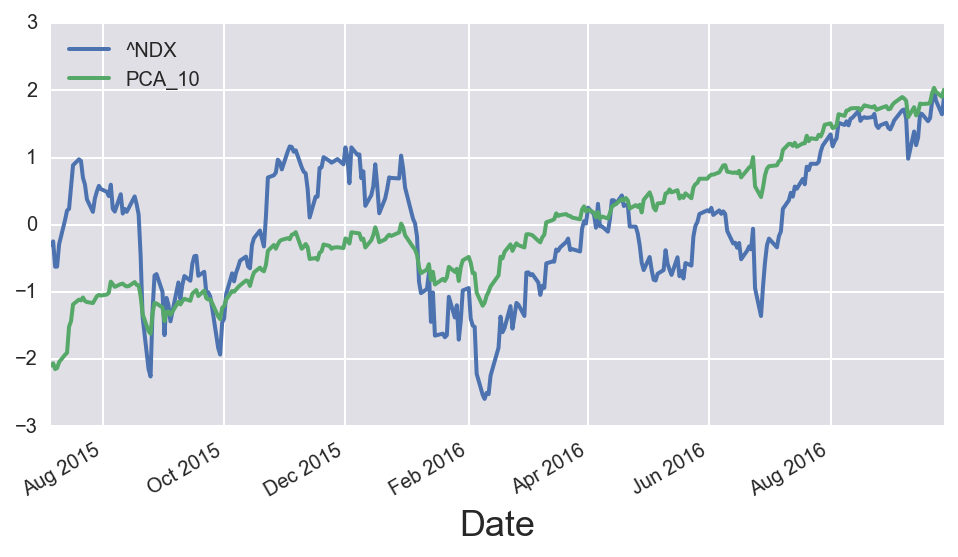

In [47]:
# create a PCA index taking the first 10 components so we can track how close it is to the real thing
pca = KernelPCA(n_components=10).fit(data.apply(scale_function))
pca_comp = pca.transform(data)
weights = get_we(pca.lambdas_)
nasdaq100['PCA_10'] = np.dot(pca_comp, weights)
nasdaq100.apply(scale_function).plot(figsize=(8,4))